In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from scipy.stats import fisher_exact
import scipy.stats as stats
from scipy.stats import norm, skew

##  Format
* Convert the variables which specify datetime in to datetime format

In [4]:
data = pd.read_excel("CASE STUDY_DATA_LATE DELIVERY ROOT CAUSE.xlsx")
data["datetime_ordered"] = pd.to_datetime(data["datetime_ordered"])
data["datetime_sourced"] = pd.to_datetime(data["datetime_sourced"])
data["datetime_planned"] = pd.to_datetime(data["datetime_planned"])
data["datetime_product_ready"] = pd.to_datetime(data["datetime_product_ready"])
data["datetime_delivered"] = pd.to_datetime(data["datetime_delivered"])

* Extract new features: Actual time taken for source, Actual time taken for make, Actual time taken for deliver


In [17]:
new_data = pd.DataFrame(columns=['source','make','deliver'])
for i in range(len(data)):
    new_data.loc[i,['source']]= pd.Timedelta(data.iloc[i,11]- data.iloc[i,10]).seconds + (pd.Timedelta(data.iloc[i,11]- data.iloc[i,10]).days)*86400
    new_data.loc[i,['make']]= pd.Timedelta(data.iloc[i,12]- data.iloc[i,11]).seconds + (pd.Timedelta(data.iloc[i,12]- data.iloc[i,11]).days)*86400
    new_data.loc[i,['deliver']] = pd.Timedelta(data.iloc[i,14].date()-data.iloc[i,12].date())
new_data.source = new_data.source/60
new_data.make =  new_data.make/3600
data1 = pd.concat([data,new_data],axis=1)
data1.to_csv('new_file.csv')

* Percentage of Fail to delivery is 10.5

In [6]:
sns.countplot('delivered_to_plan', data=data)
plt.tight_layout()
plt.savefig('Delivered.jpeg',dpi=300)

In [8]:
data = pd.read_csv('new_file7.csv')
data.returned.fillna('N',inplace = True)
data.backorder.fillna('N',inplace = True)
country = pd.get_dummies(data['country'],prefix='country',drop_first=True)
shipping_method = pd.get_dummies(data['shipping_method'],prefix='shipping',drop_first=True)
product_category = pd.get_dummies(data['product_category'],prefix='product_category',drop_first=True)
facility = pd.get_dummies(data['facility'],prefix='facility',drop_first=True)
on_sale =  pd.get_dummies(data['on_sale'],prefix='onsale',drop_first=True)
Returned =  pd.get_dummies(data['returned'],prefix='Returned',drop_first=True)
Backorder = pd.get_dummies(data['backorder'],prefix='Returned',drop_first=True)
data_new = pd.concat([country,shipping_method,facility,product_category,on_sale,Returned,Backorder,data['units_per_order'],
          data['transit_days'],data['source'],data['make'],data['Exact_deliver_time'],data['delivered_to_plan'],data['Actual_timetaken'],data['Planned_days']],axis=1)


In [9]:
data_new1 = data_new.drop(['Returned_Y', 'source','make','Exact_deliver_time','delivered_to_plan','Planned_days'], axis=1)

In [18]:
plt.figure(figsize=(16,10))
sns.heatmap(data_new1.corr(),annot=True, cmap='viridis')
plt.tight_layout()
plt.savefig('cor.jpeg',dpi=300)

In [23]:
data.describe()

,units_per_order,transit_days,deadline_source,deadline_make,deadline_deliver,source,make,Planned_days,Actual_timetaken,Allocated_deadline,Exact_deliver_time
count,110114.000000,110114.000000,110114.000000,110114.000000,110114.000000,110114.000000,110114.000000,110114.000000,110114.000000,110114.000000,110114.000000
mean,1.042329,2.381305,1336.617297,40.581806,3.515829,322.997842,22.085806,4.456698,3.429708,6.134944,2.285162
std,0.496093,1.113712,1105.341513,25.320339,1.741056,1206.938771,16.359120,2.307207,2.170577,2.412693,1.985657
min,1.000000,1.000000,1.000000,1.000000,1.000000,34.400000,0.004444,-0.833889,-0.091991,1.150000,-0.942222
25%,1.000000,2.000000,479.000000,23.000000,2.000000,59.083333,11.251389,2.843137,1.887057,4.305035,0.647616
50%,1.000000,2.000000,1104.000000,32.000000,3.000000,82.933333,18.122917,4.290000,3.181910,6.034028,1.913437
75%,1.000000,3.000000,1566.000000,52.000000,5.000000,165.866667,27.228125,5.794219,4.664549,7.746528,3.602254
max,50.000000,8.000000,6392.000000,168.000000,14.000000,66040.450000,494.641111,52.905139,47.905139,18.931250,45.660544


## Feature Importances through Random Forest

In [24]:
from sklearn.ensemble import RandomForestRegressor
rnd_clf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
rnd_clf.fit(data_new1.iloc[:,:-1], data_new1.Actual_timetaken)
importances = rnd_clf.feature_importances_
indices = np.argsort(importances)
features = data_new1.iloc[:,:-1].columns
plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.tight_layout()
plt.savefig('feature.jpeg',dpi=300)

In [15]:
data1 = pd.concat([data_new1.Actual_timetaken,data_new1.transit_days], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='transit_days', y="Actual_timetaken", data=data1)
f.savefig('boxplot.jpeg', bbox_inches='tight')

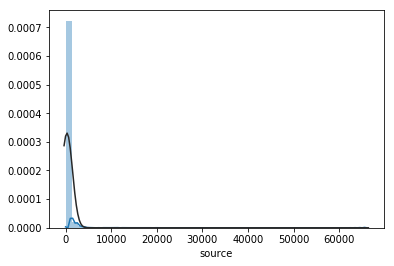

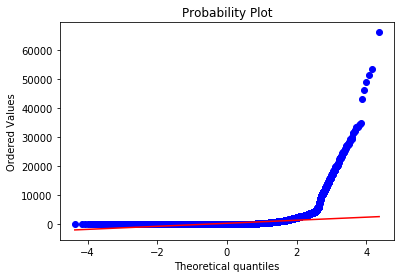

In [52]:
sns.distplot(data.source, fit=norm);
fig = plt.figure()
res = stats.probplot(data.source, plot=plt)
plt.show()

## Planning stage
***
- More than 98 percentage of delivery fails happen due to poor planning
- More than 98.14 percentage of time the product achieved the individual steps deadline, but still fails to deliver the product

In [122]:
Failure_due_plan = (len(new_data[(new_data['source'] == True) & (new_data['make'] == True ) & (new_data['deliver'] == True ) & (new_data['Actual_deliver'] == False )])/len(new_data[(new_data['Actual_deliver'] == False)]))*100
Failure_due_plan

98.14511258735226

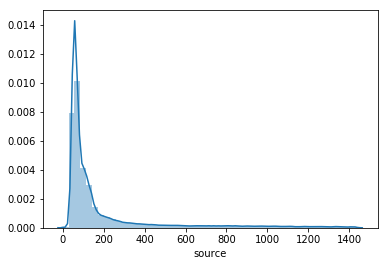

In [56]:
sns.distplot(data2['source'])
plt.show()

* If the product is not delivered as per the plan (datetime_planned), the output variable (delivered_to_plan) denote that deliver as "FAIL"
* Below table support the above statement

In [122]:
data2 = pd.read_csv('new_file1.csv')
data = pd.read_csv('new_file.csv')
data["datetime_ordered"] = pd.to_datetime(data["datetime_ordered"])
data["datetime_delivered"] = pd.to_datetime(data["datetime_delivered"])
data["datetime_planned"] = pd.to_datetime(data["datetime_planned"])
check_date = (data["datetime_planned"] - data["datetime_delivered"]).dt.days >= 0
tab = pd.crosstab(check_date,data.delivered_to_plan)
tab

delivered_to_plan,FAIL,PASS
row_0,,
False,11591,0
True,0,98523


## Chi-square test of independence
* The late delivery (delivered_to_plan = FAIL) is not affecting the products return
* Chi square test and the percentage of fail to deliver (percentage_fail) results support the above statement

In [51]:
percentage_fail = sum(data[data.returned == 'Y'].delivered_to_plan == 'FAIL')/len(data[data.returned == 'Y'].returned)
print(percentage_fail)print(tab)
print(fisher_exact(tab))

0.117731141576
delivered_to_plan  FAIL   PASS
returned                      
N                  9779  84944
Y                  1812  13579
(0.86272291403410506, 8.5916796590609461e-08)


* The backorders and the late deliveries are indepedent. Backorder is not causing the late deliveries
* Chi square test and the percentage of fail to deliver (percentage_fail) results support the above statement

In [57]:
percentage_fail = sum(data[data.backorder == 'Y'].delivered_to_plan == 'FAIL')/len(data[data.backorder == 'Y'].backorder)
print(percentage_fail)
tab = pd.crosstab(data.backorder.fillna('N'),data.delivered_to_plan)
print(tab)
print(fisher_exact(tab))

0.178447563997
delivered_to_plan  FAIL   PASS
backorder                     
N                  9430  88574
Y                  2161   9949
(0.49015123232774921, 7.8497228698822166e-148)


In [2]:
data = pd.read_csv('new_file7.csv')


* The product categories and the late deliveries are independent.
* The shipping method and the late deliveries are independent
* The facility and the late deliveries are independent
* There is a significant relationship between on sale method and late deliveries (p<0.1)


In [16]:
tab = pd.crosstab(data.product_category,data.delivered_to_plan)
print(tab)
g, p, dof, expctd = stats.chi2_contingency(tab, lambda_="log-likelihood")
print(p)

delivered_to_plan  FAIL   PASS
product_category              
ACCESSORIES         708   6976
JACKETS & VESTS    7356  59983
TOPS               3527  31564
3.54767496283e-08


In [15]:
tab = pd.crosstab(data.shipping_method,data.delivered_to_plan)
print(tab)
g, p, dof, expctd = stats.chi2_contingency(tab, lambda_="log-likelihood")
print(p)

delivered_to_plan  FAIL   PASS
shipping_method               
2-Day               663   2529
3-Day              1780  13695
Ground             6993  69828
Next Day           2155  12471
4.17085599917e-156


In [18]:
tab = pd.crosstab(data.facility,data.delivered_to_plan)
print(tab)
g, p, dof, expctd = stats.chi2_contingency(tab, lambda_="log-likelihood")
print(p)

delivered_to_plan  FAIL   PASS
facility                      
ANTWERP            1082   9171
AUGSBURG           2592  23574
EINDHOVEN          2412  16125
HANOVER            1809  15730
MANCHESTER         1467  14529
OXFORD             2229  19394
1.37951118882e-32


In [19]:
tab = pd.crosstab(data.on_sale,data.delivered_to_plan)
print(tab)
g, p, dof, expctd = stats.chi2_contingency(tab, lambda_="log-likelihood")
print(p)

delivered_to_plan  FAIL   PASS
on_sale                       
N                  5713  47658
Y                  5878  50865
0.0634492154027


* If the actual time taken is greater than planned number of days, it will fail to reach the customer before the promised deadline as we expected. The below table support this argument.
* 66% ((7674)/(7674+3917)) of delivery fails happened due to poor planning
* The sum of internal deadlines is mostly higher than the dealine given for the customer (87.9)


In [18]:
data = pd.read_csv('new_file.csv')
new_data = pd.DataFrame(columns=['Planned_days','Actual_diff'])
for i in range(len(data)):
    new_data.loc[i,['Actual_diff']] = int(data.loc[i,'deliver'].strip()[0])
Actual_diff = ((data.source/1440) + (data.make/24) + new_data['Actual_diff'])
new_data['Actual_diff'] = Actual_diff
data["datetime_planned"] = pd.to_datetime(data["datetime_planned"])
data["datetime_ordered"] = pd.to_datetime(data["datetime_ordered"])
data['temp']  = data['datetime_planned'] - data['datetime_ordered']

In [19]:
for i in range(len(data)):
    new_data.loc[i,['Planned_days']] = int(data.loc[i,'temp'].days) + ((data.loc[i,'datetime_planned'] - data.loc[i,'datetime_ordered']).seconds)/86400
Allocated_deadline = (data['deadline_source']/1440) + (data['deadline_make']/24) + data['deadline_deliver']
data3 = pd.concat([data,new_data,Allocated_deadline],axis=1)
data3.rename(columns={0: 'Allocated_deadline','Actual_diff': 'Actual_timetaken'}, inplace = True)

In [20]:
data3["datetime_product_ready"] = pd.to_datetime(data3["datetime_product_ready"])
data3["datetime_delivered"] = pd.to_datetime(data3["datetime_delivered"])
data3['temp1']  = data3["datetime_delivered"] - data3["datetime_product_ready"]
new_data1 = pd.DataFrame(columns=['Exact_deliver_time'])
for i in range(len(data3)):
    new_data1.loc[i,['Exact_deliver_time']] = int(data3.loc[i,'temp1'].days) + ((data3.loc[i,'datetime_delivered'] - data3.loc[i,'datetime_product_ready']).seconds)/86400
Actual_diff = ((data3.source/1440) + (data3.make/24) + new_data1['Exact_deliver_time'])
data3['Actual_timetaken'] = Actual_diff

In [21]:
temp =(data3.Planned_days - data3.Actual_timetaken)
temp1 = temp.apply(lambda x: round(x,2))
tab = pd.crosstab(temp1>=0,data3.delivered_to_plan)
print(tab)

delivered_to_plan   FAIL   PASS
row_0                          
False              11591      0
True                   0  98523


In [23]:
data2 = pd.read_csv('new_file1.csv')
new_data = pd.DataFrame(columns=['source','make','deliver','Actual_deliver'])
new_data['source'] = data2.source>=0
new_data['make'] = data2.make>=0
new_data['deliver'] = data2.deliver>=0
Fail_due_deliver_stage = len(data3[(new_data['deliver'] == False) &(data3.delivered_to_plan == 'FAIL')])
Fail_due_make_stage = len(data3[(new_data['make'] == False) &(data3.delivered_to_plan == 'FAIL')])
Fail_due_make_source = len(data3[(new_data['source'] == False) &(data3.delivered_to_plan == 'FAIL')])
print('The number of delivery fails due to deliver stage failure is:',Fail_due_deliver_stage)
print('The number of delivery fails due to make stage failure is:',Fail_due_make_stage)
print('The number of delivery fails due to source stage failure is:',Fail_due_make_source)


The number of delivery fails due to deliver stage failure is: 0
The number of delivery fails due to make stage failure is: 0
The number of delivery fails due to source stage failure is: 0


In [24]:
sum(data3.Allocated_deadline- data3.Planned_days>0)/len(data3)

0.87909802568247453

In [4]:
data3 = pd.read_csv('new_file7.csv')

## Master Table

In [8]:
temp0 = data3.Planned_days - data3.Actual_timetaken
temp7 = temp0.apply(lambda x: round(x,2))


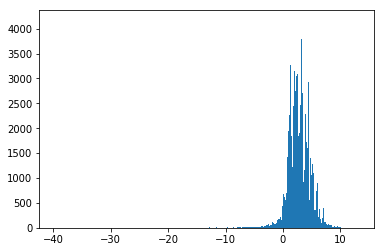

In [9]:
temp1 =data3.Allocated_deadline - data3.Actual_timetaken
temp2 = temp1.apply(lambda x: round(x,2))

plt.hist(temp2, bins='auto')
plt.show()

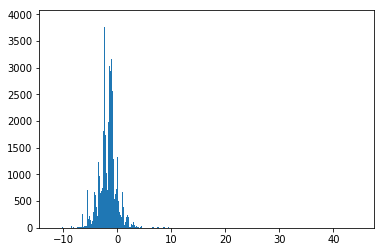

In [10]:
temp3 = data3.Planned_days - data3.Allocated_deadline 
temp4 = temp3.apply(lambda x: round(x,2))
plt.hist(temp4, bins='auto')
plt.show()

In [11]:
Delivered_by_plan = temp7 >= 0
Finished_bef_internal_deadline = temp2>=0
Allocated_reasonable_deadline = temp4 >=0
dataframe = pd.concat([Delivered_by_plan,Finished_bef_internal_deadline,Allocated_reasonable_deadline,data3.delivered_to_plan],axis=1)
dataframe.columns = ['Delivered_by_plan','Finished_bef_internal_deadline','Allocated_reasonable_deadline','delivered_to_plan']
unique_rows = dataframe.drop_duplicates()


In [12]:
count = pd.DataFrame(columns = ['Count'])
for i in range(len(unique_rows)):
    count.loc[i,['Count']] = sum((dataframe.iloc[:,0] == unique_rows.iloc[i,0]) & (dataframe.iloc[:,1] == unique_rows.iloc[i,1]) & (dataframe.iloc[:,2] == unique_rows.iloc[i,2]) & (dataframe.iloc[:,3] == unique_rows.iloc[i,3]))
unique_rows.reset_index(drop=True, inplace=True)
count.reset_index(drop=True, inplace=True)

In [13]:
df1 = pd.concat( [unique_rows, count], axis=1) 
df1

,Delivered_by_plan,Finished_bef_internal_deadline,Allocated_reasonable_deadline,delivered_to_plan,Count
0,True,True,False,PASS,85744
1,True,False,True,PASS,2066
2,True,True,True,PASS,10713
3,False,True,False,FAIL,8560
4,False,False,False,FAIL,2497
5,False,False,True,FAIL,534


* The percentage of late delivery is approximately 10.5 (11591 FAILS)
* Out of 11591 fails, 11057 fails happened due to poor planning (Internal deadlines for 
the processes are greater than customer delivery time). 
* The planning stage didn't considers internal deadlines before calculating customer delivery dates. Out of 110114 delivers, 96801 products (approximately 87.9%) internal deadline periods are greater than customer delivery periods




In [14]:
df1[df1.delivered_to_plan == 'FAIL']

,Delivered_by_plan,Finished_bef_internal_deadline,Allocated_reasonable_deadline,delivered_to_plan,Count
3,False,True,False,FAIL,8560
4,False,False,False,FAIL,2497
5,False,False,True,FAIL,534


In [46]:
print('The percentage of late delivery:',sum(df1[df1.delivered_to_plan == 'FAIL'].Count)/len(data3))
sum(df1[df1.delivered_to_plan == 'FAIL'].Count)

The percentage of late delivery: 0.10526363586828197


11591

In [33]:
data4 = pd.concat([data3,new_data1],axis=1)
data4.to_csv('new_file7.csv')

In [57]:
new_data2 = pd.DataFrame(columns=['source_fail','make_fail','deliver_fail'])
temp = pd.DataFrame(columns=['temp'])
new_data2.source_fail = (check5.deadline_source - check5.source)<0
new_data2.make_fail = (check5.deadline_make - check5.make)<0
for i in range(len(check5)):
    temp.loc[i,'temp'] = pd.Timedelta(check5.deliver.iloc[i]).days
new_data2.deliver_fail = (check5.deadline_deliver -  temp.temp)<0   

* 534 delivery fails happened due to internal deadline failure. The major contribution comes from make step.

In [63]:
np.sum(new_data2)

source_fail     140
make_fail       266
deliver_fail      2
dtype: int64

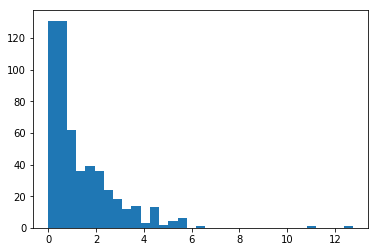

In [37]:
check5 = data3[(dataframe.Delivered_by_plan == False) & (dataframe.Finished_bef_internal_deadline == False) &
         (dataframe.Allocated_reasonable_deadline == True) & (dataframe.delivered_to_plan == 'FAIL')]
plt.hist(check5.Planned_days - check5.Allocated_deadline, bins='auto')
plt.show()